In [28]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine

import torch
from transformers import BertModel, BertTokenizer

import matplotlib.pyplot as plt
import seaborn as sn

### Example sentences

In [4]:
sentences = ['Computer networking may be considered a branch of electrical engineering.',
             'Computer networking is part of the electronics engineering field.',
             'Computer networking is a lot of business.',
             'Any data sent across a network requires time to travel from source to destination.',
             'The information pushed to the network needs time to go from point A to point B.',
             'The travel time of the data is instantaneous.',
             'Firewalls are typically configured to reject access requests from unrecognized sources.',
             'Firewalls are usually set up to refuse access requests from unknown sources.',
             'Firewalls allow actions from all foreign sources.'
]

### Encode sentences

In [8]:
def encode_sentences(model_name_or_path, sentences):
    """
    Given a list of sentences an d a model, get the embeddings of theses sentences
    as the average of the word embeddings of the last layer.
    """
    print("   Loading pretrained model/tokenizer...")
    tokenizer = BertTokenizer.from_pretrained(model_name_or_path)
    model = BertModel.from_pretrained(model_name_or_path, output_hidden_states=True, cache_dir ='../_cache') # Will output all hidden_states.

    print("   Tokenizing sentences...")
    tokenized = [tokenizer.encode(sent, add_special_tokens=True) for sent in sentences]

    max_len = 0
    for i in tokenized:
        if len(i) > max_len:
            max_len = len(i)
    print("   Maximum length in dataset: {}".format(max_len))

    print("   Padding/Truncating sentences according to the maximum length...")
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized])

    print("   Creating attention masks...")
    attention_mask = np.where(padded != 0, 1, 0)  #returns ndarray which is 1 if padded != 0 is True and 0 if False.

    print("   Converting inputs to torch tensors...")
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    print("   Encoding sentences...")
    with torch.no_grad():
        # output is a 2-tuple where:
        #  - output[0] is the last_hidden_state, i.e a tensor of shape (batch_size, sequence_length, hidden_size).
        #  - output[1] is the pooler_output, i.e. a tensor of shape (batch_size, hidden_size) being the last layer hidden-state of the first token of the sequence (classification token).
        #  - output[2] are all hidden_states, i.e. a 13-tuple of torch tensors of shape (batch_size, sequence_length, hidden_size): 12 encoders-outputs + initial embedding outputs.
        output = model(input_ids, attention_mask=attention_mask)

    # Concatenate the tensors for all layers. We use `stack` here to create a new dimension in the tensor.
    hidden_states = torch.stack(output[2], dim=0)

    # Switch around the “layers” and “tokens” dimensions with permute.
    hidden_states = hidden_states.permute(1,2,0,3)

    # For each sentence, take the embeddings of its word from the last layer and represent that sentence by their average.
    last_hidden_states = output[0]
    sentence_embeddings = [torch.mean(embeddings, dim=0).numpy() for embeddings in last_hidden_states]
    sentence_embeddings = np.array(sentence_embeddings)

    # Create pandas dataframe.
    cols = ['feat'+str(i) for i in range(sentence_embeddings.shape[1])]
    df = pd.DataFrame(data=sentence_embeddings[:,:], columns=cols)
    df['Sentence'] = sentences
    return df

print("BERT-base")
bert_df = encode_sentences('bert-base-cased', sentences)
print("NetBERT")
netbert_df = encode_sentences('../_models/netbert/checkpoint-1027000/', sentences)


BERT-base
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Maximum length in dataset: 21
   Padding/Truncating sentences according to the maximum length...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
NetBERT
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Maximum length in dataset: 21
   Padding/Truncating sentences according to the maximum length...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...


In [20]:
def compute_cosine_matrix(embeddings):
    """
    """
    matrix = np.zeros((len(sentences), len(sentences)))
    for i, sent in enumerate(sentences):
        for j, sent in enumerate(sentences):
            matrix[i,j] = 1 - cosine(embeddings[i], embeddings[j])
    return matrix


# Get embeddings.
bert_embeddings = bert_df.loc[:, bert_df.columns != 'Sentence'].values
netbert_embeddings = netbert_df.loc[:, netbert_df.columns != 'Sentence'].values

# Compute matrix.
bert_matrix = compute_cosine_matrix(bert_embeddings)
netbert_matrix = compute_cosine_matrix(netbert_embeddings)

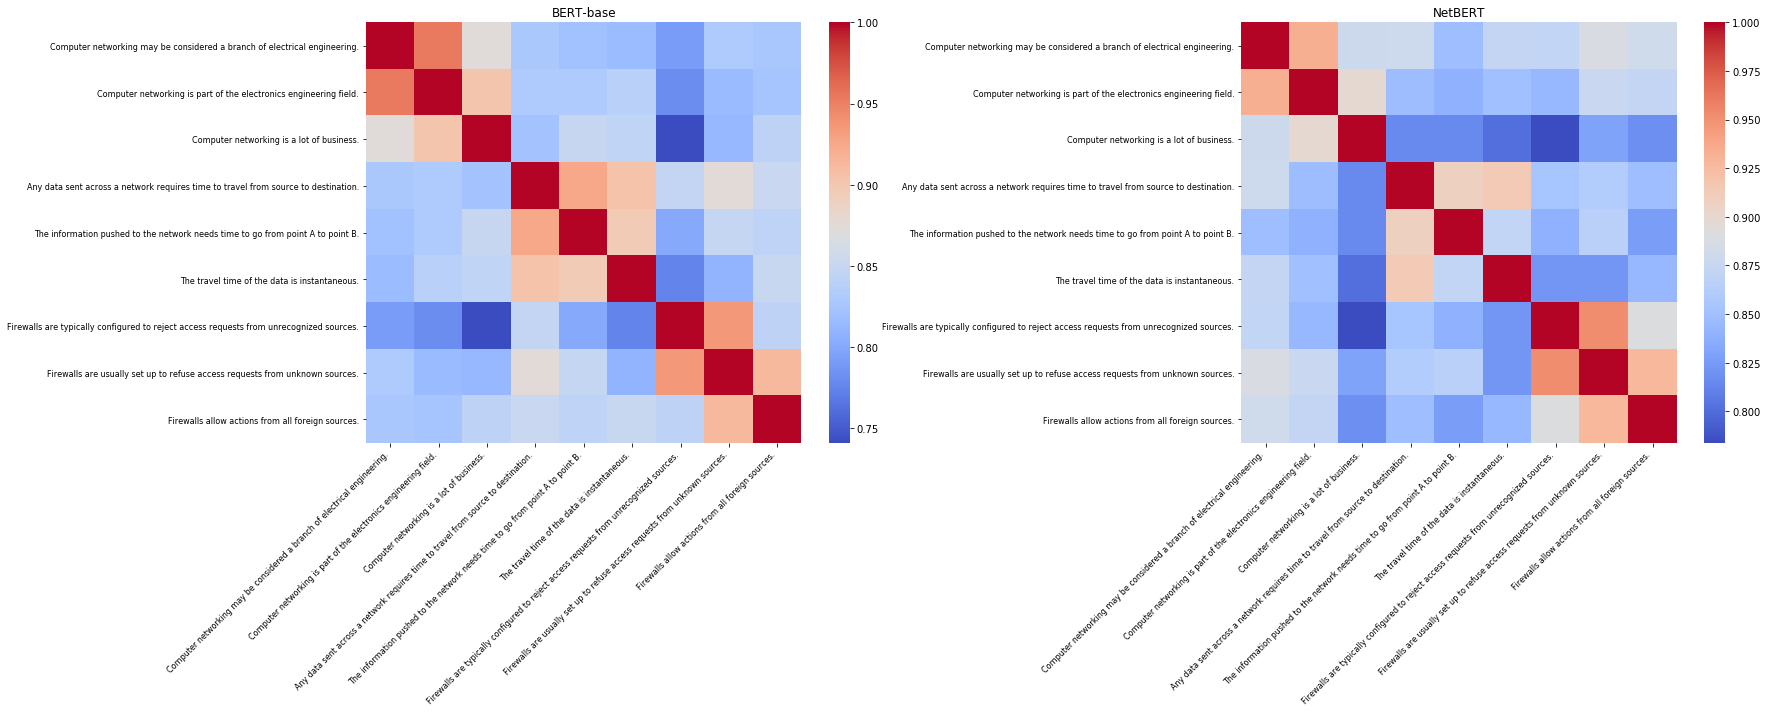

In [42]:
fig = plt.figure(figsize=(25,10))

# Create dataframes.
bert_cm = pd.DataFrame(bert_matrix, index=sentences, columns=sentences)
netbert_cm = pd.DataFrame(netbert_matrix, index=sentences, columns=sentences)

# Create heatmaps.
ax1 = fig.add_subplot(1, 2, 1)
sn.heatmap(bert_cm, annot=False, cmap="coolwarm")
ax1.set_xticklabels(ax.get_xticklabels(), fontsize=8, horizontalalignment='right', rotation=45) 
ax1.set_yticklabels(ax.get_yticklabels(), fontsize=8)
ax1.set_title("BERT-base")

ax2 = fig.add_subplot(1, 2, 2)
sn.heatmap(netbert_cm, annot=False, cmap="coolwarm")
ax2.set_xticklabels(ax.get_xticklabels(), fontsize=8, horizontalalignment='right', rotation=45) 
ax2.set_yticklabels(ax.get_yticklabels(), fontsize=8)
ax2.set_title("NetBERT")

plt.tight_layout()
plt.show()
#plt.savefig(outdir+"confusion_matrix.png")

## Observations

* In the first square:
    - The two first sentences (the "similar" ones) are more similar according to BERT than NetBERT.
    - The third sentence ("dissimilar" one) is more dissimilar to the first two according to NetBERT.
* In the second square:
    - The third sentence ("dissimilar" one) is more dissimilar to the second one according to NetBERT.
* In the third square:
    - The third sentence ("dissimilar" one) is more dissimilar to the first one according to NetBERT.